# Building UNet Model on OxfordIIITPet Dataset

____

In [47]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import Subset

import numpy as np
from typing import List as list
from typing import Tuple as tuple

%matplotlib inline

___

### Transformer

In [48]:
#!g1.1
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('/kaggle/input/oxfordiiitpet-input/OxfordIIITPet/', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('/kaggle/input/oxfordiiitpet-input/OxfordIIITPet/', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

valid_subset = Subset(valid_dataset, idx)

In [49]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
valid_subset_loader = DataLoader(valid_subset, batch_size=32, shuffle=False)

___

### Necessary functions

In [50]:
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [51]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [52]:
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [53]:
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [54]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()
        
        print(f'Valid accuracy on {epoch} = {valid_accuracy}')

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

        if valid_accuracy >= 0.89: 
            print("Reached 89% accuracy on validation set. Stopping training.")
            break
        
    print(f'Valid accuracy = {valid_accuracy}')

In [55]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    predictions = []
    model = model.to(device)
    model.eval()  # set the model to evaluation mode

    with torch.no_grad():  # deactivate autograd
        for x, _ in loader:  # we do not need 'y' for predictions
            x = x.to(device)
            output = model(x)  # forward pass
            preds = output.argmax(dim=1)  # get the predicted classes
            predictions.append(preds)

    return torch.cat(predictions)

___

### Building a Model

In [56]:
def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)
        self.up5 = conv_plus_conv(base_channels * 32, base_channels * 8)

        self.bottleneck = conv_plus_conv(base_channels * 16, base_channels * 16)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)
        residual1 = self.down1(x)  
        x = self.downsample(residual1)  
        
        residual2 = self.down2(x)  
        x = self.downsample(residual2) 

        residual3 = self.down3(x)  
        x = self.downsample(residual3) 
        
        residual4 = self.down4(x)  
        x = self.downsample(residual4)  
        
        residual5 = self.down5(x)  
        x = self.downsample(residual5)  

        
        x = self.bottleneck(x)  
        

        x = nn.functional.interpolate(x, scale_factor=2)  
        x = torch.cat((x, residual5), dim=1)  
        x = self.up5(x)  
        
        x = nn.functional.interpolate(x, scale_factor=2)  
        x = torch.cat((x, residual4), dim=1) 
        x = self.up4(x)  
        
        x = nn.functional.interpolate(x, scale_factor=2)  
        x = torch.cat((x, residual3), dim=1)  
        x = self.up3(x)  
        
        x = nn.functional.interpolate(x, scale_factor=2)  
        x = torch.cat((x, residual2), dim=1)  
        x = self.up2(x) 

        x = nn.functional.interpolate(x, scale_factor=2) 
        x = torch.cat((x, residual1), dim=1)  
        x = self.up1(x) 

        x = self.out(x)  

        return x


___

### Model Training and Evaluation

In [57]:
# for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


print(device)

loss_fn = nn.CrossEntropyLoss()

cuda:0


In [58]:
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Valid accuracy on 14 = 0.890987634333904


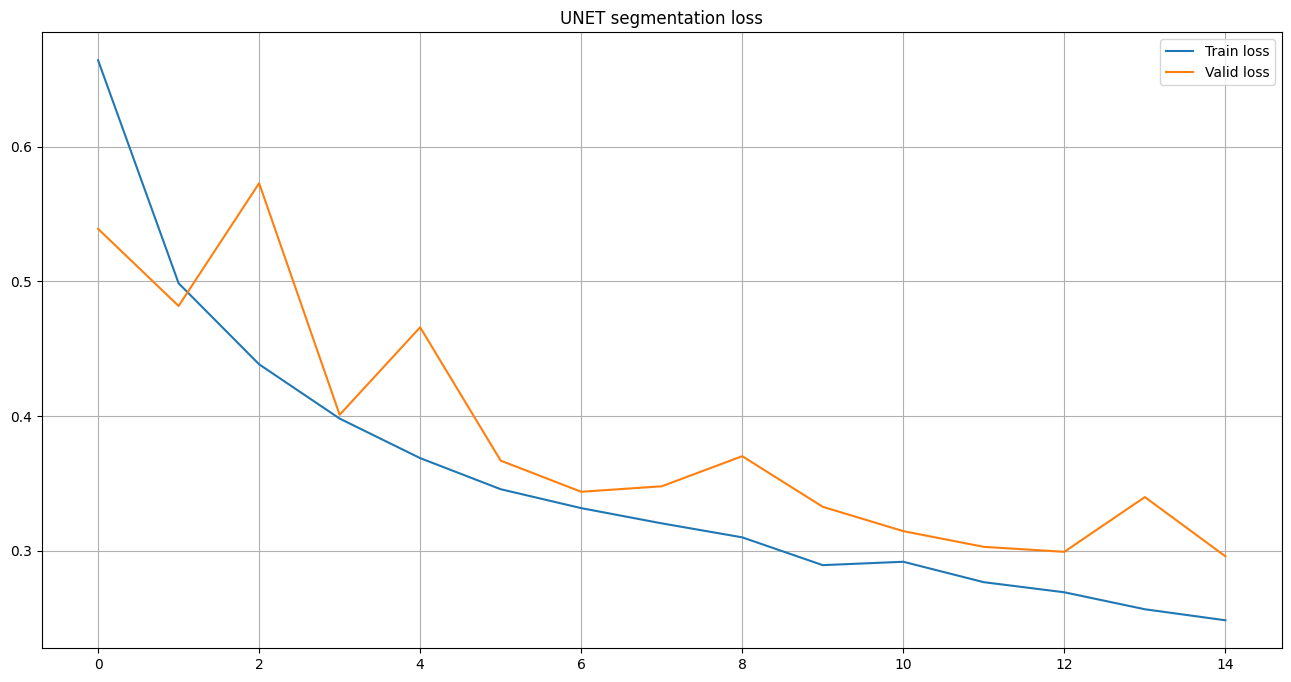

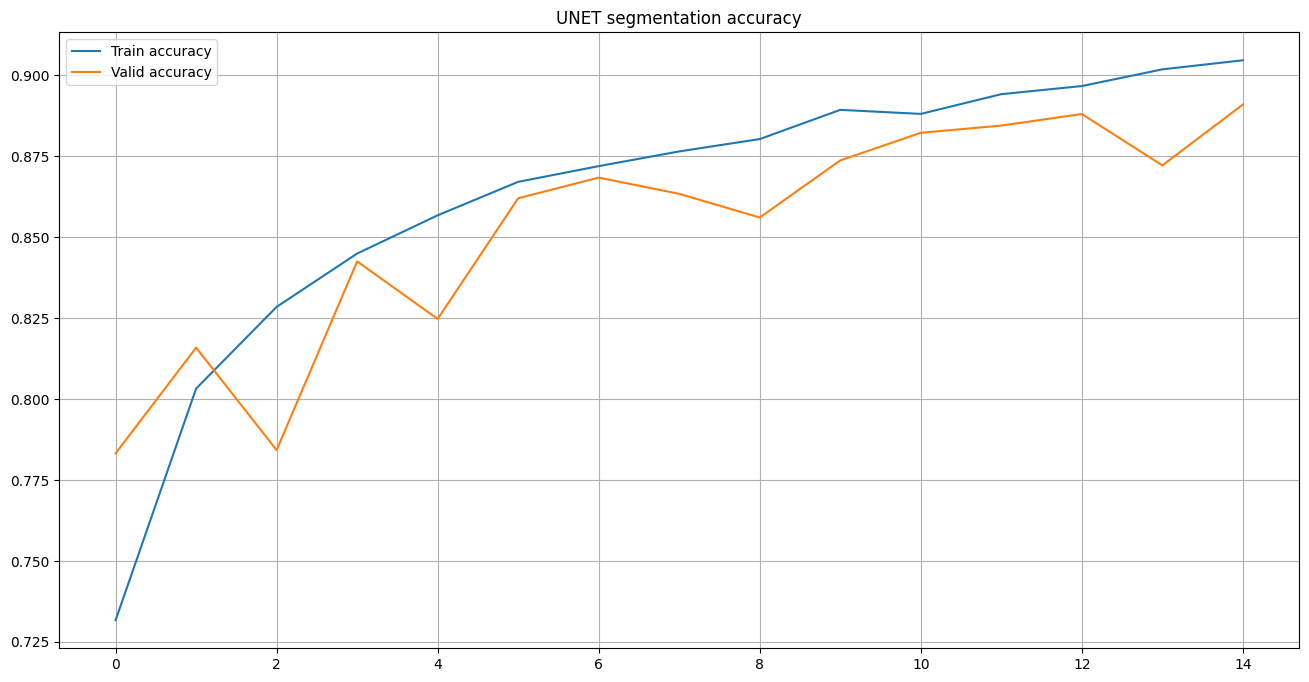

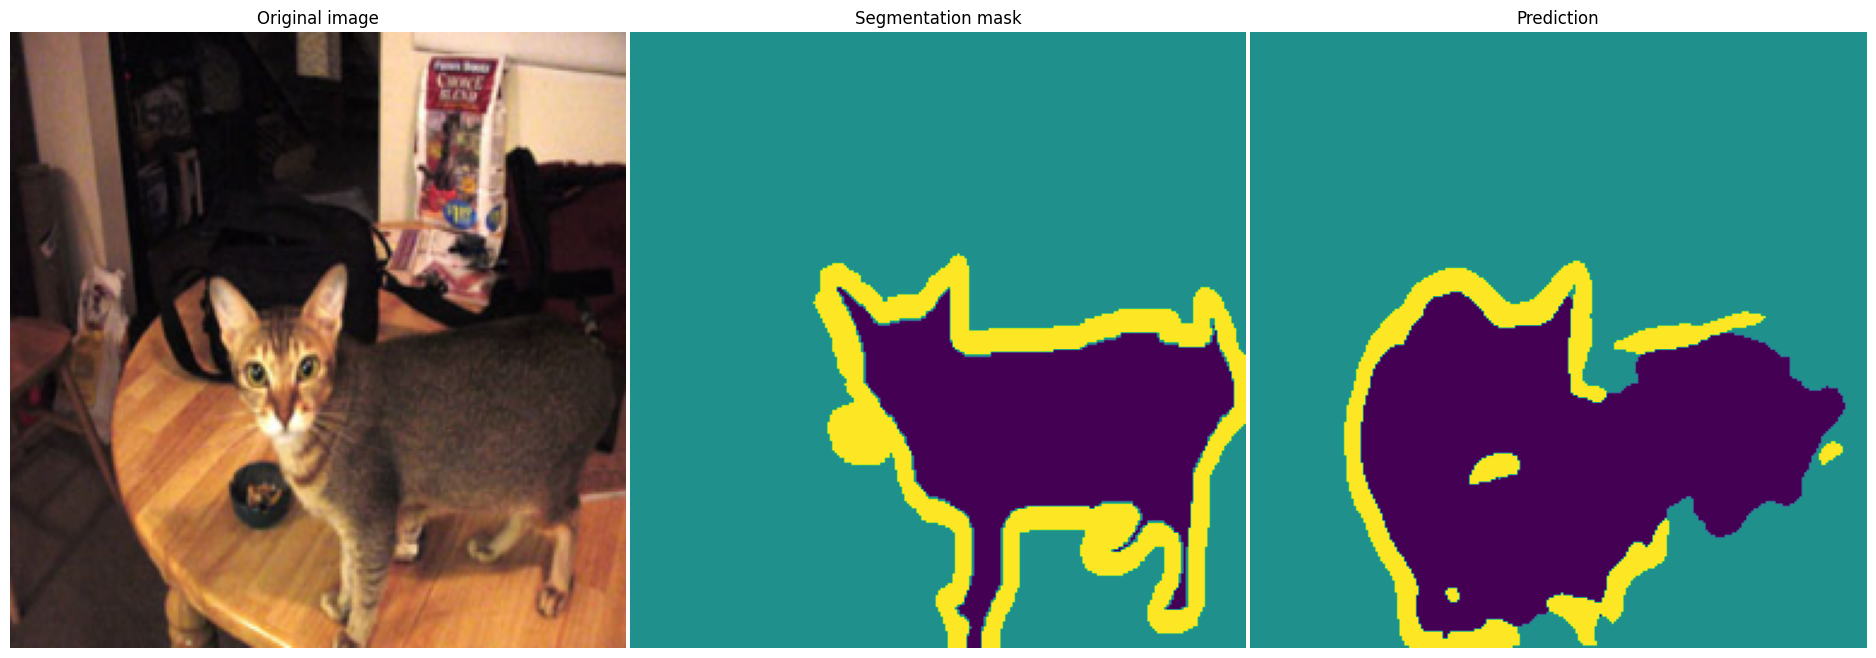

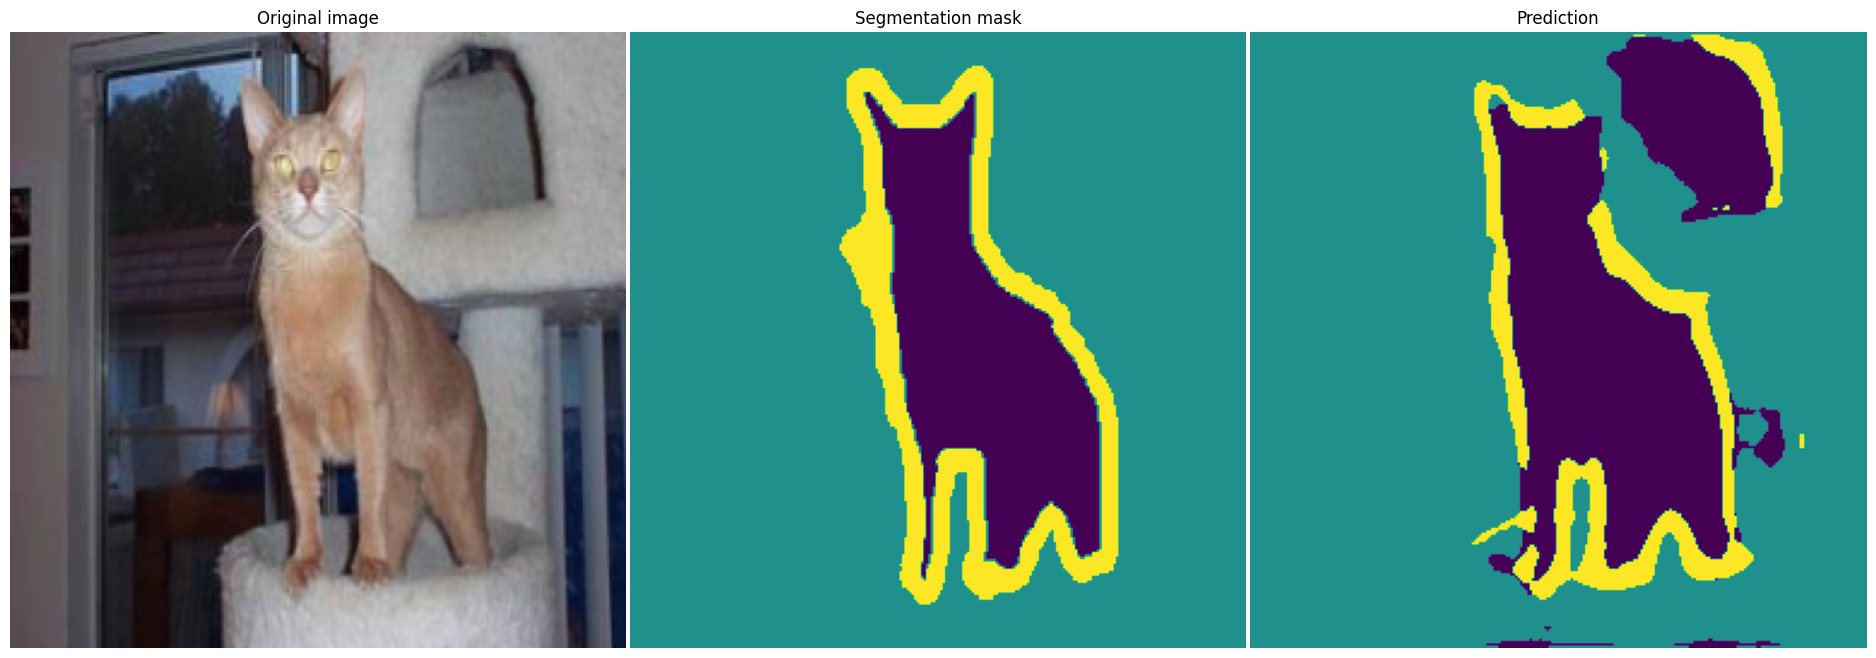

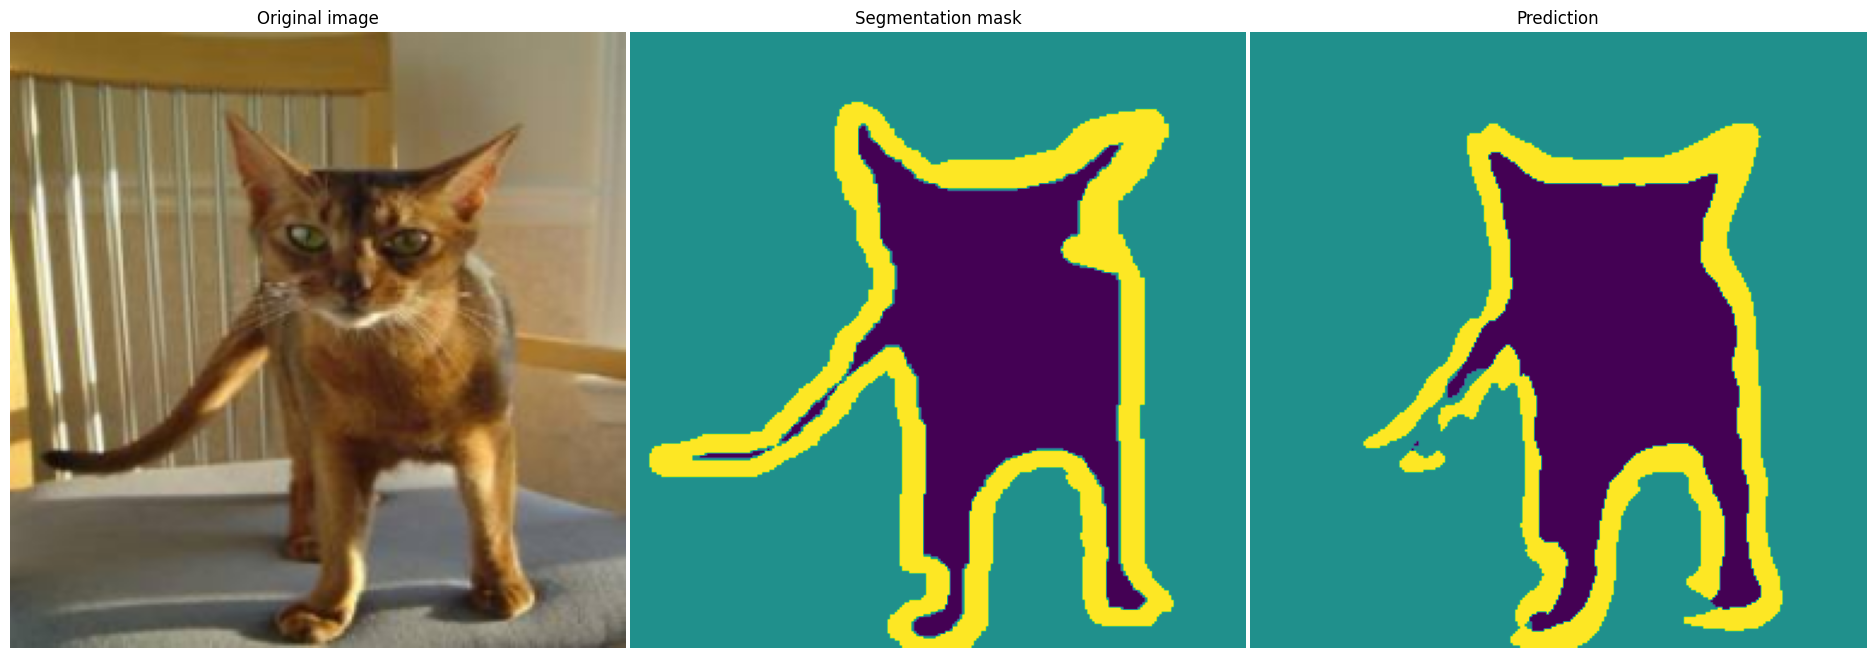

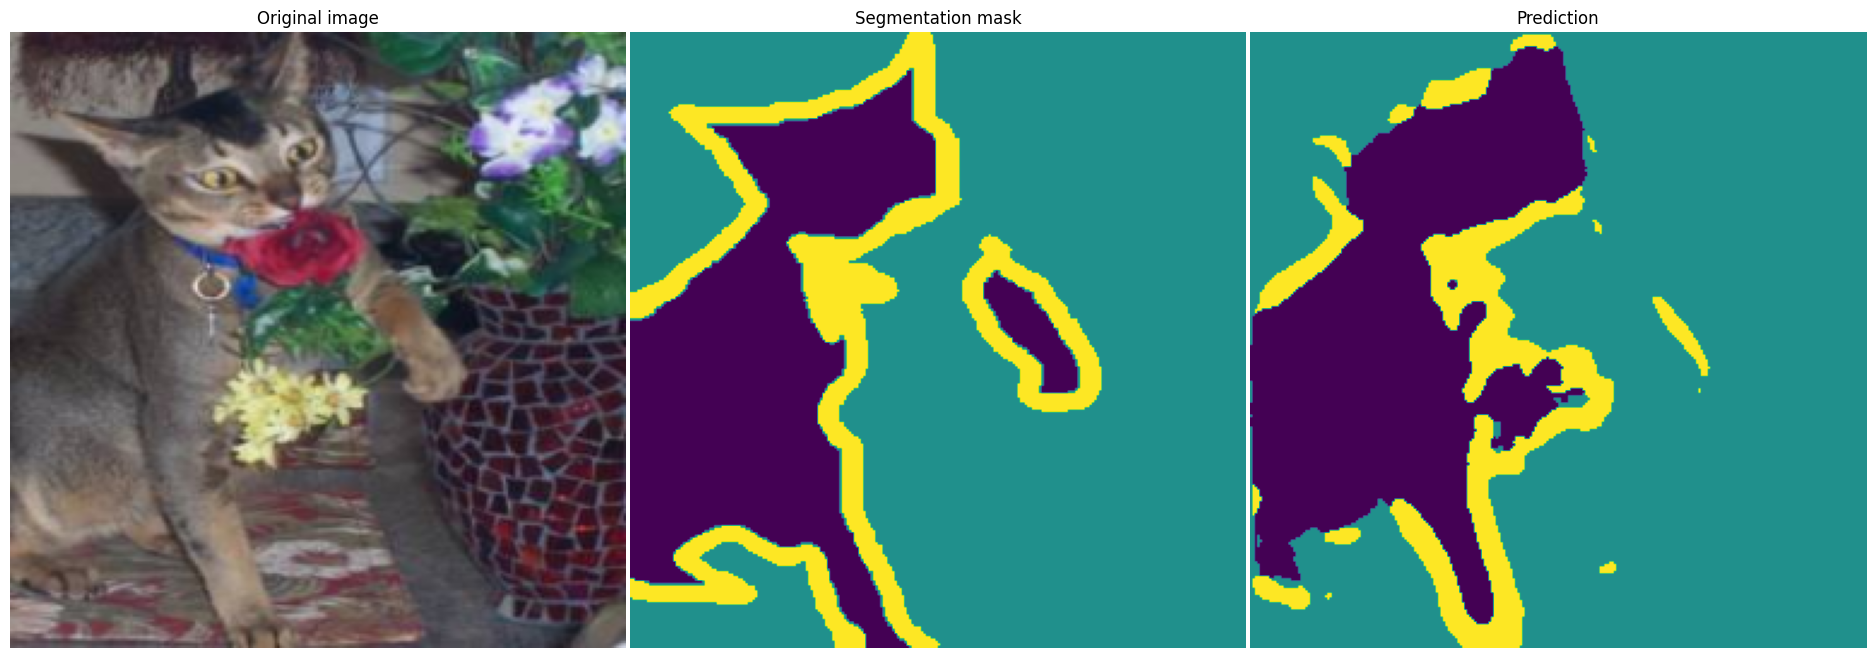

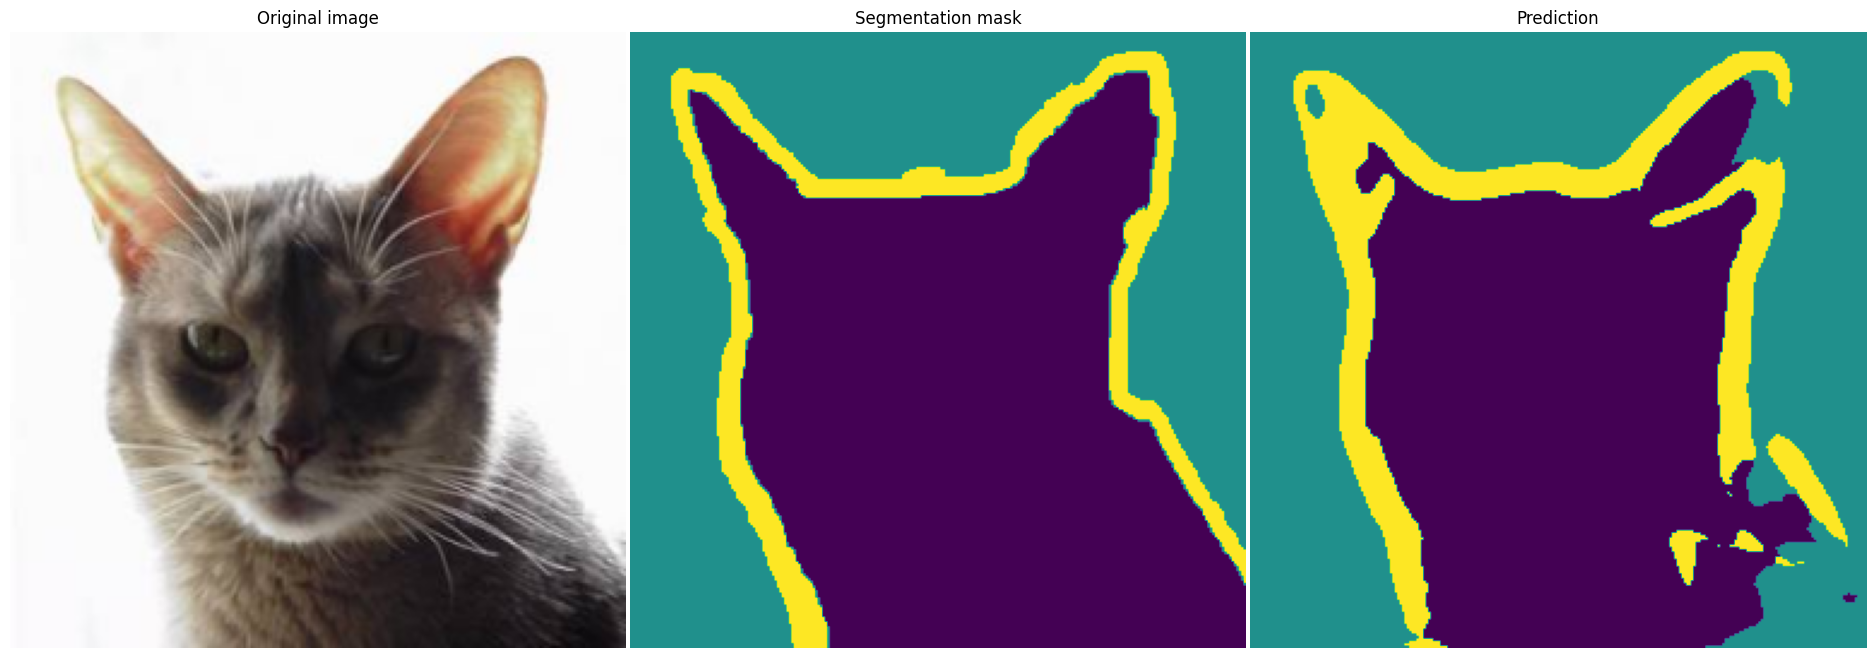

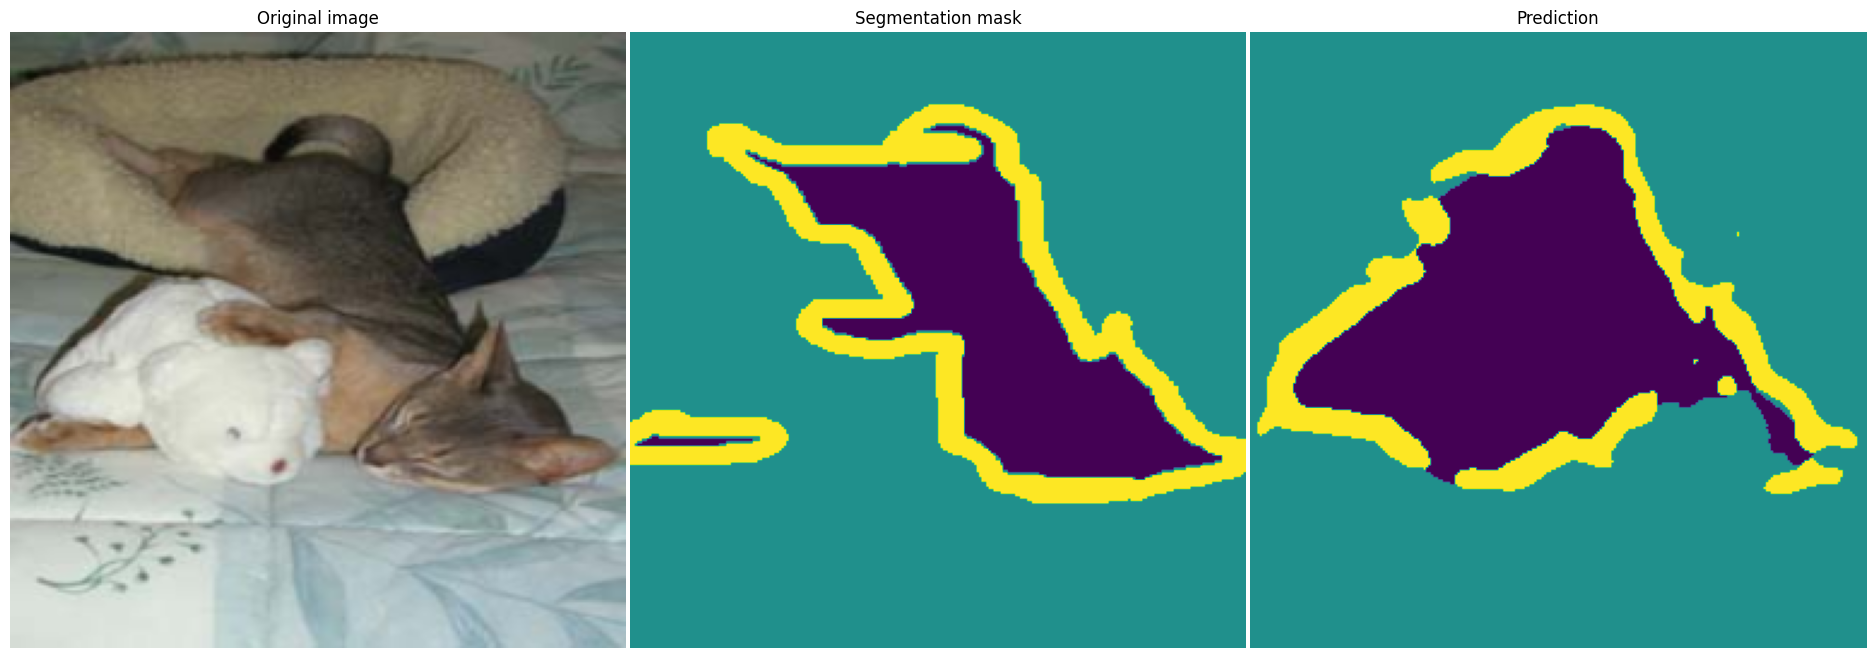

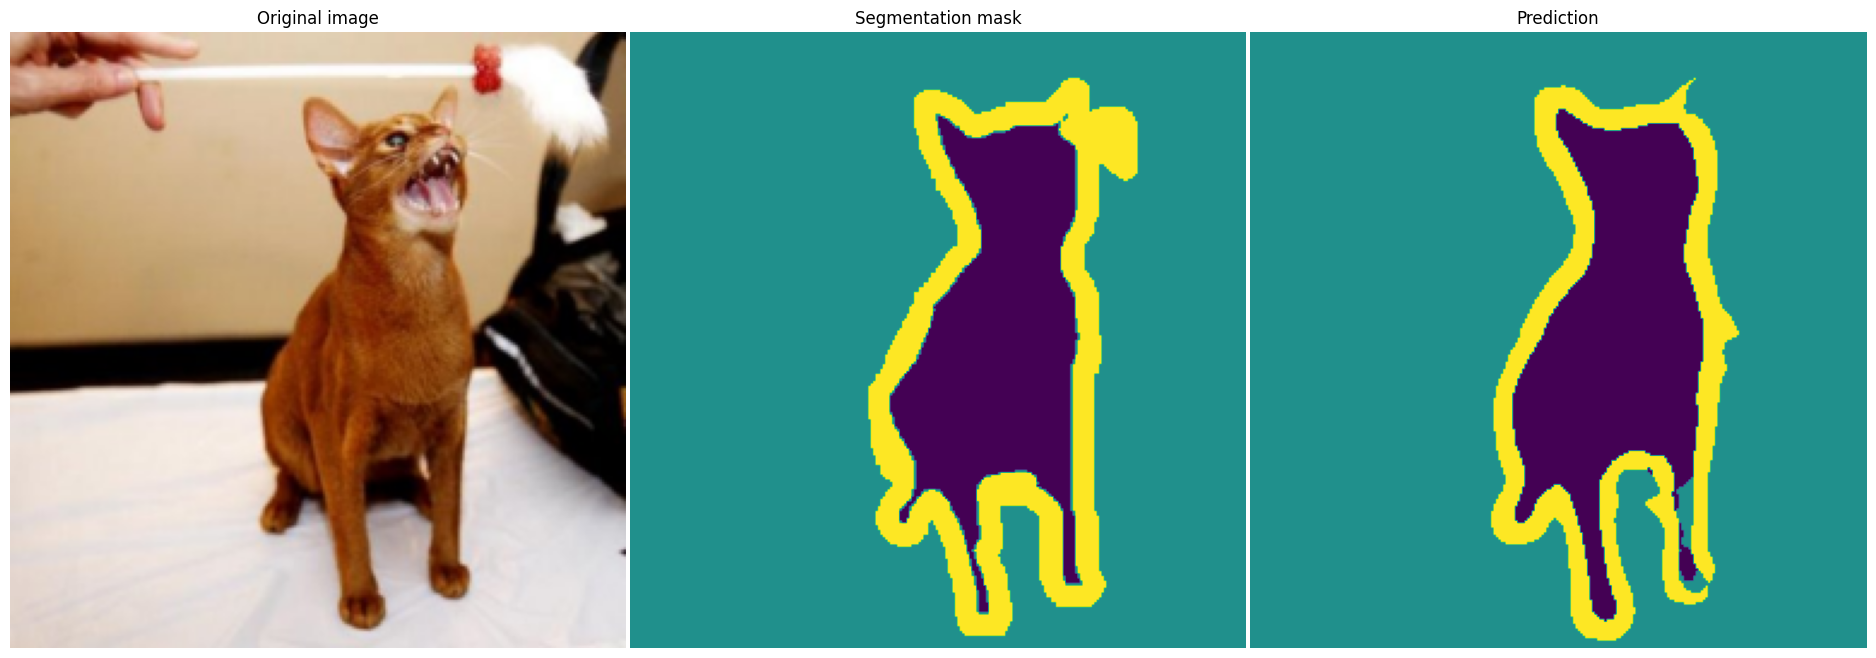

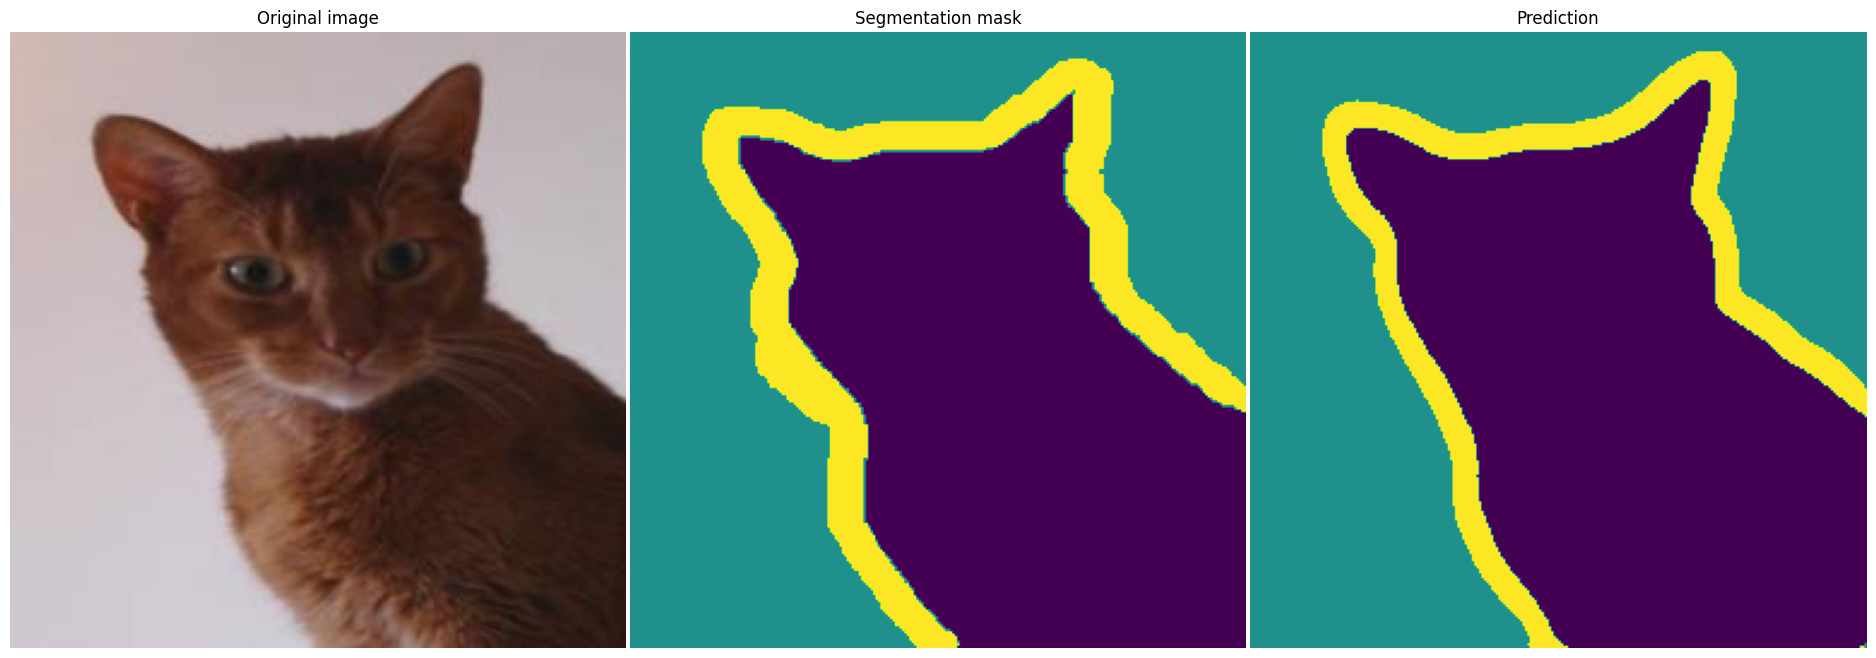

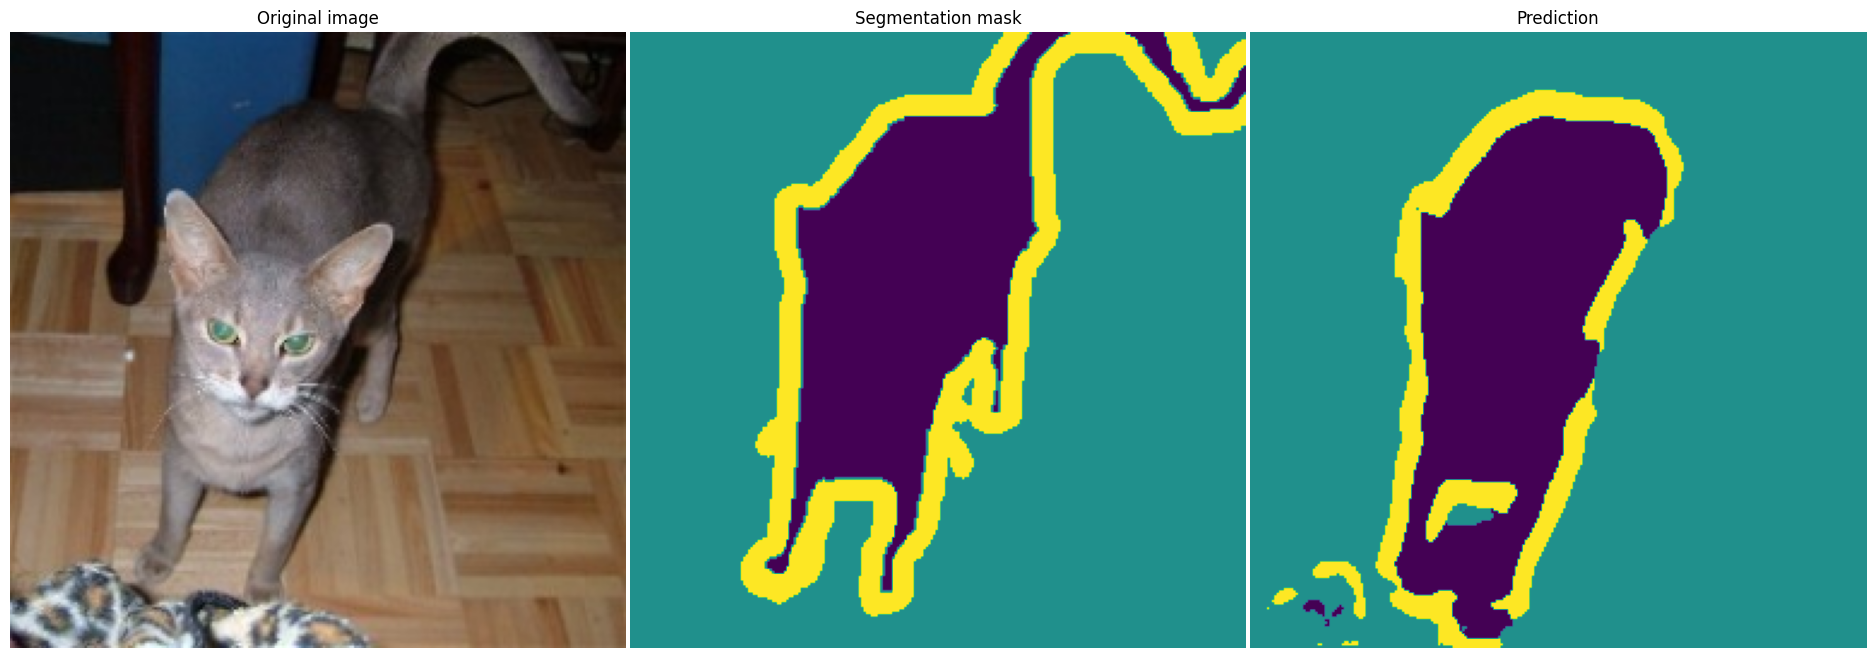

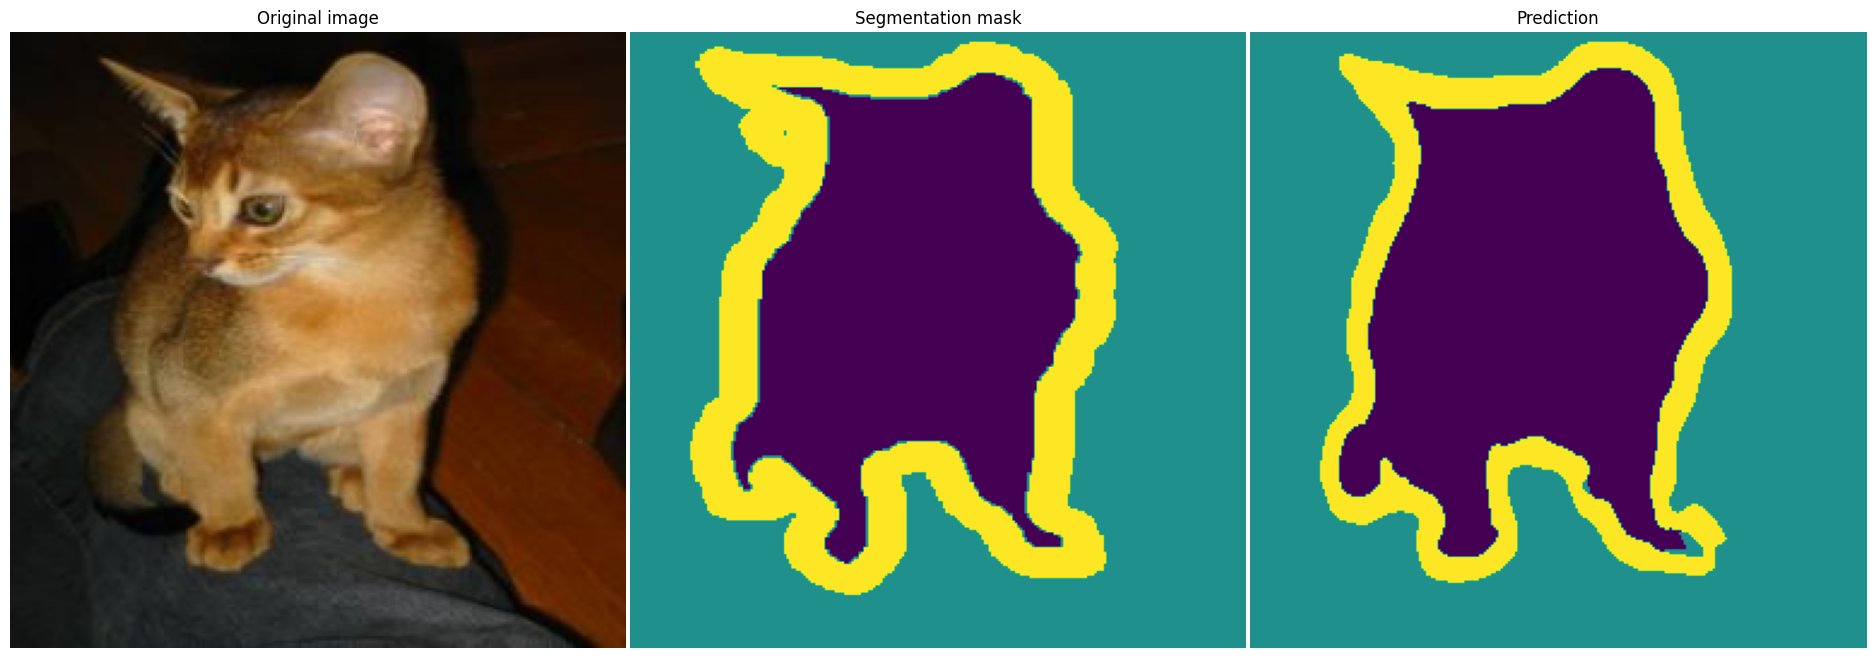

Reached 89% accuracy on validation set. Stopping training.
Valid accuracy = 0.890987634333904


In [59]:
whole_train_valid_cycle(model, 15, 'UNET segmentation')

In [60]:
predictions = predict(model, valid_subset_loader, device).unsqueeze(1).to(torch.uint8)

In [61]:
predictions.shape

torch.Size([200, 1, 256, 256])

In [62]:
torch.save(predictions, 'predictions.pt')

____